In [1]:
from google.colab import files
import pandas as pd
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.decomposition import PCA


# Import Data

In [2]:
uploaded_train = files.upload()
df_train = pd.read_csv(io.BytesIO(uploaded_train['Train_data.csv']))

Saving Train_data.csv to Train_data (3).csv


In [3]:
uploaded_test = files.upload()
df_test = pd.read_csv(io.BytesIO(uploaded_test['Test_data.csv']))

Saving Test_data.csv to Test_data.csv


In [90]:
np.unique(df_train['class'], return_counts=True)

(array(['anomaly', 'normal'], dtype=object), array([11743, 13449]))

# Visualize Data

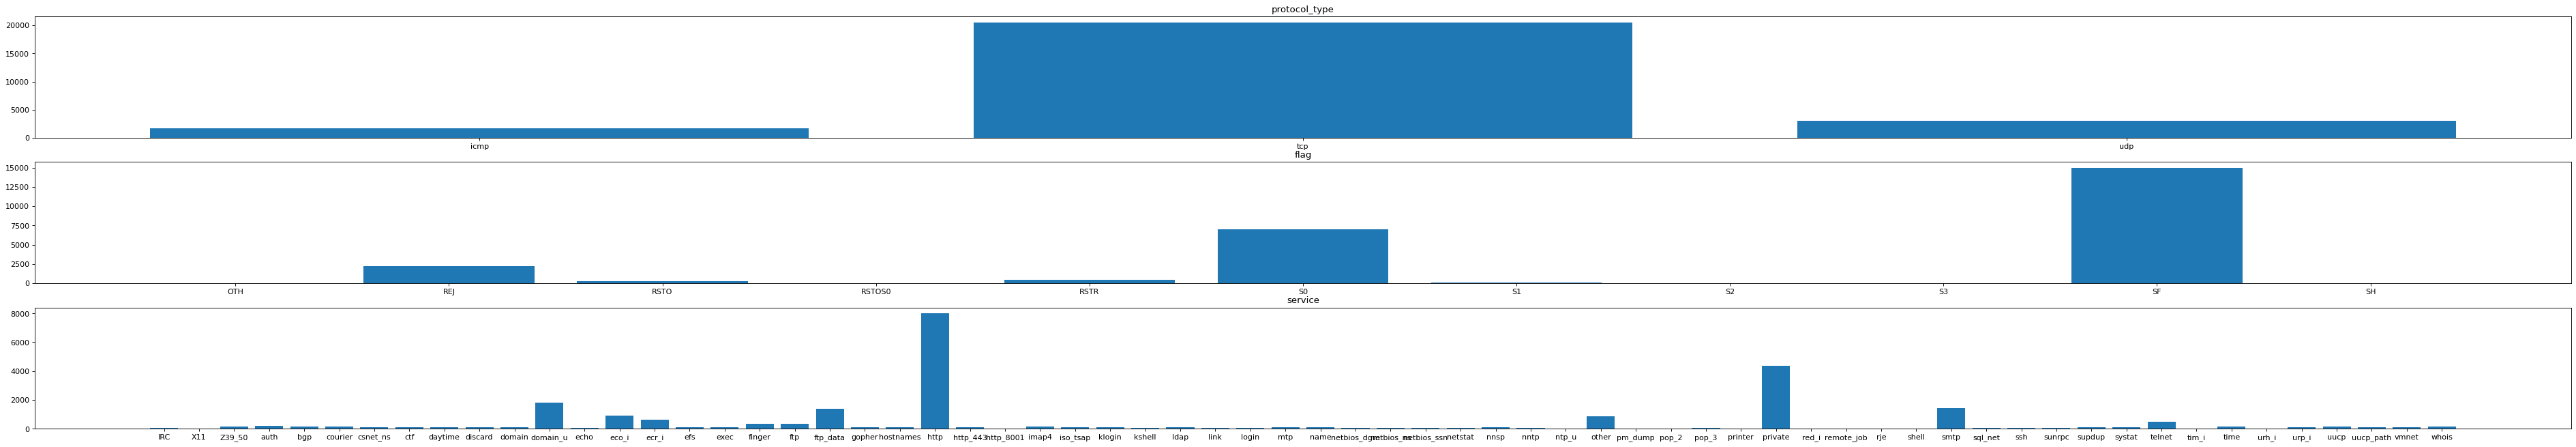

In [98]:
p1x1,p1y1 = np.unique(df_train.protocol_type, return_counts = True)
p2x1,p2y1 = np.unique(df_train.flag, return_counts = True)
p3x1,p3y1 = np.unique(df_train.service, return_counts = True)


fig, axs = plt.subplots(3,1,figsize = (60,10), dpi = 80)
axs[0].bar(p1x1,p1y1)
axs[0].set_title('protocol_type')
axs[1].bar(p2x1, p2y1)
axs[1].set_title('flag')
axs[2].bar(p3x1, p3y1)
axs[2].set_title('service')
plt.show()

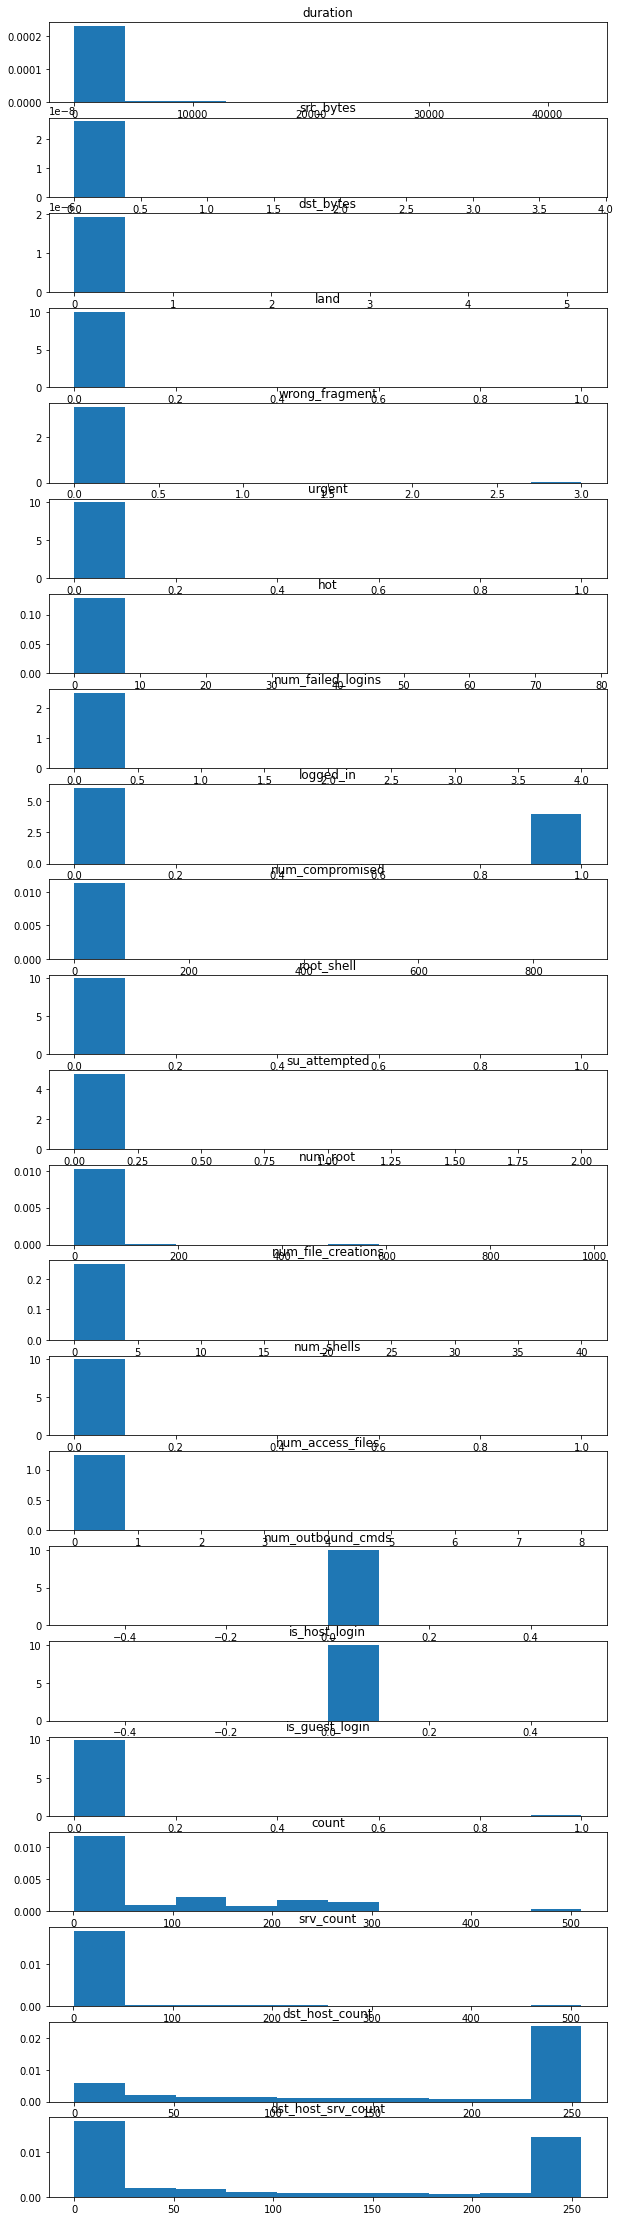

In [96]:
features_int = df_train.columns[df_train.dtypes == 'int64']
df_train.loc[: , features_int]

columns = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']
fig, axs = plt.subplots(23,1,figsize = (10,40))
for i,j in enumerate(columns):
  axs[i].hist(df_train.loc[:, j], density = True)
  axs[i].set_title(j)
plt.show()



Text(0.5, 1.0, 'Normalized Entropy of Int features')

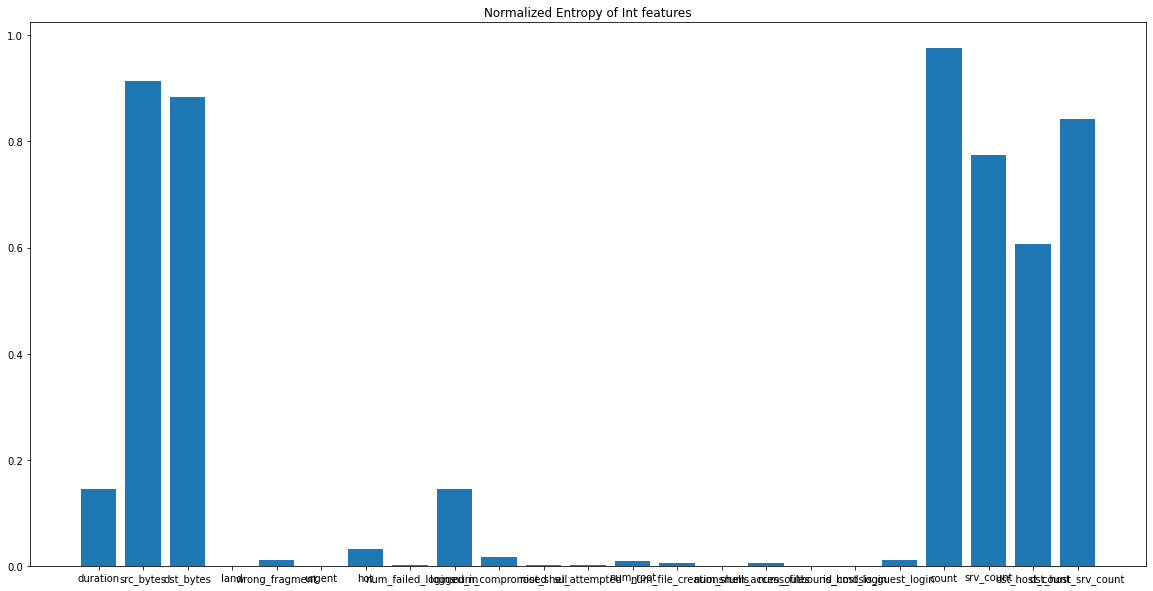

In [97]:
def probability_values(series):
  c,v = np.unique(series, return_counts=True)
  v_prob = v / np.sum(v)
  return(v_prob)

entropy_all = []
for i in columns:
  entropy_all.append(stats.entropy(probability_values(df_train.loc[:, i])) / 4.6)

plt.figure(figsize = (20,10))
plt.bar(columns, entropy_all)
plt.title("Normalized Entropy of Int features")

In [ ]:
features_float = df_train.columns[df_train.dtypes == 'float64']
df_train.loc[: , features_float]

,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,1.0,1.0,0.0,0.0,0.05,0.07,0.00,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.2,0.2,0.0,0.0,1.00,0.00,0.00,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0.0,0.0,1.0,1.0,0.07,0.07,0.00,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00
25188,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00
25189,0.0,0.0,1.0,1.0,0.07,0.07,0.00,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00
25190,1.0,1.0,0.0,0.0,0.14,0.06,0.00,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00


# one hot encoding

In [3]:
df_train_obj = df_train.select_dtypes(include=[object]).iloc[:, :-1]
df_train_obj.shape
df_train_obj.columns

Index(['protocol_type', 'service', 'flag'], dtype='object')

In [4]:
le = preprocessing.LabelEncoder()
df_train_le = df_train_obj.apply(le.fit_transform)
df_train_le.head()


,protocol_type,service,flag
0,1,19,9
1,2,41,9
2,1,46,5
3,1,22,9
4,1,22,9


In [5]:
encrypt = preprocessing.OneHotEncoder()
encrypt.fit(df_train_le)
onehotlabels = encrypt.transform(df_train_le).toarray()
onehotlabels.shape

(25192, 80)

In [6]:
df_train_encoded = pd.concat([df_train.select_dtypes(exclude=[object]), pd.DataFrame(onehotlabels)], axis = 1) 
df_train_encoded

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,0,1,...,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25188,0,334,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,18,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# PCA

## sklearn Implementation

In [7]:
#@title sklearn implementation
pca = PCA(n_components=118)
pca.fit(df_train_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


PCA(n_components=118)

In [120]:
#@title my implementation
def pca_my(X,k): 
    mean = X - np.mean(X,axis = 0)
    cov_mat = np.cov(mean, rowvar = False)
    evalues, evectors = np.linalg.eigh(cov_mat)
    sorted_evalues_index = evalues.argsort()[::-1][:k]
    k_evalues = evalues[sorted_evalues_index]
    k_evector = evectors[sorted_evalues_index]
    X_reduced = np.dot(mean, k_evector.transpose())
    return (X_reduced, k_evalues, evalues)

reduced_trainX, k_evalues, evalues = pca_my(df_train_encoded, 118)

In [123]:
pd.DataFrame({'Eigenvalue_from_my_implementation': np.sort(evalues)[::-1], 
              'Eigenvalue from Sklearn Implementation': pca.explained_variance_,
              'percent_var_my_implementation': np.cumsum(np.sort(evalues)[::-1] / np.sum(evalues)),
              'percent_var_sk_learn': np.cumsum(pca.explained_variance_ratio_)}).head(3)

,Eigenvalue_from_my_implementation,Eigenvalue from Sklearn Implementation,percent_var_my_implementation,percent_var_sk_learn
0,5.811983e+12,5.811983e+12,0.998643,0.998643
1,7.890795e+09,7.890795e+09,0.999999,0.999999
2,7.164672e+06,7.164672e+06,1.000000,1.000000


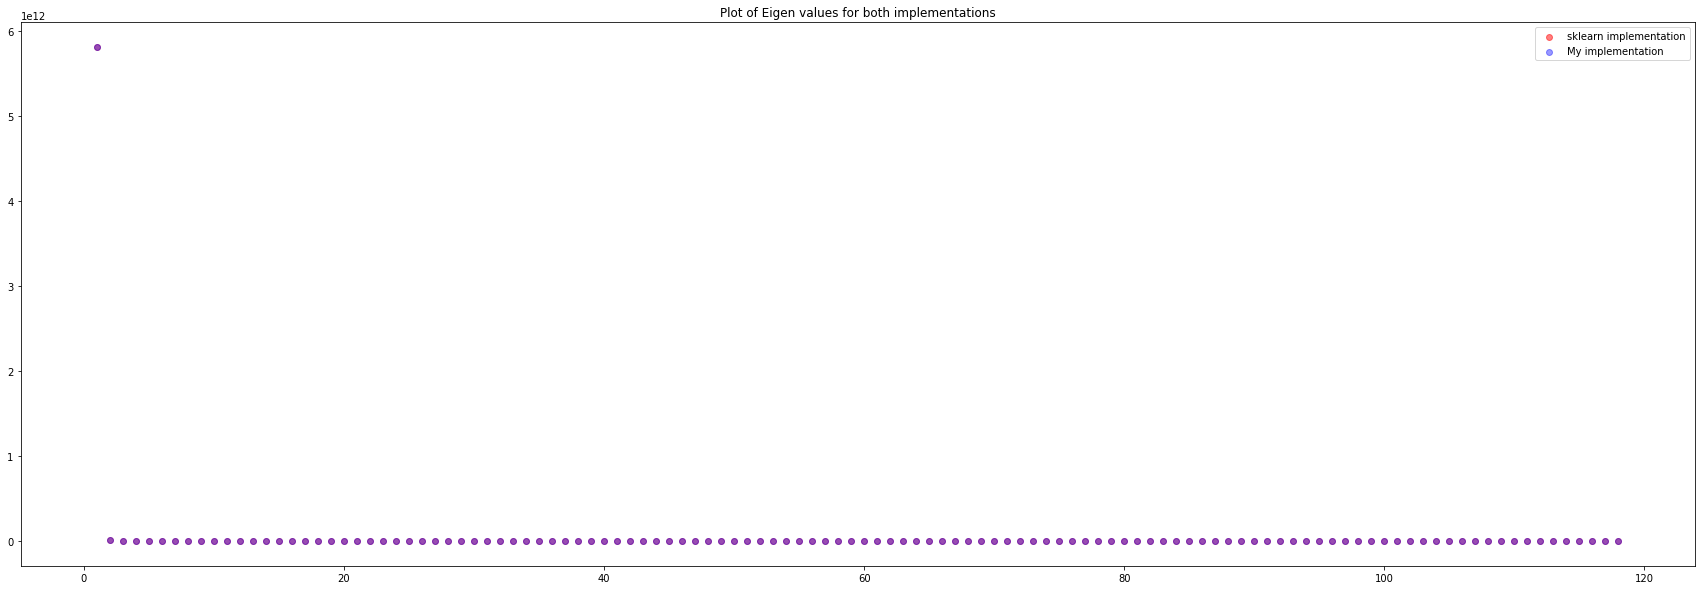

In [124]:
plt.figure(figsize=(30,10))
plt.scatter(np.arange(1,119), pca.explained_variance_, color = 'r', label = 'sklearn implementation', alpha = 0.5)
plt.scatter(np.arange(1,119), np.sort(evalues)[::-1], color = 'b', label = 'My implementation', alpha = 0.4)
plt.legend()
plt.title("Plot of Eigen values for both implementations")
plt.show()

## Visualizing data using top 2 PC

In [8]:
df_train_reduced = pd.DataFrame(np.dot(df_train_encoded, pca.components_[:2].T), columns=['eigenvector_1', 'eigenvector_2'])
df_train_reduced['label'] = df_train['class']

In [9]:
label_int = []
for i in df_train_reduced.label:
  if i == 'normal':
    label_int.append(0)
  if i == 'anomaly':
    label_int.append(1)

df_train_reduced['label_int'] = label_int

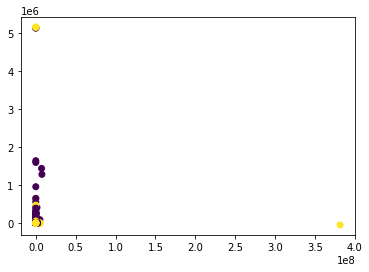

In [10]:
plt.scatter(df_train_reduced.eigenvector_1, df_train_reduced.eigenvector_2, c = df_train_reduced.label_int)


In [128]:
df_train_reduced_without_outlier = df_train_reduced[(df_train_reduced.eigenvector_1 < 10000) & 
                  (df_train_reduced.eigenvector_2 < 10000)]

In [129]:
label_int = []
for i in df_train_reduced_without_outlier.label:
  if i == 'normal':
    label_int.append(0)
  if i == 'anomaly':
    label_int.append(1)

df_train_reduced_without_outlier['label_int'] = label_int

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


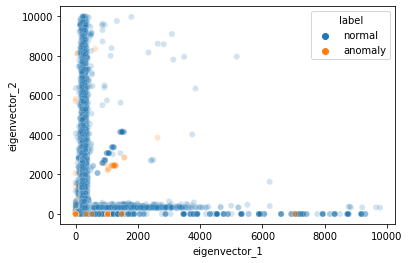

In [132]:
import seaborn as sns
sns.scatterplot(df_train_reduced_without_outlier.eigenvector_1, df_train_reduced_without_outlier.eigenvector_2, 
                hue= df_train_reduced_without_outlier.label, alpha = 0.2)
plt.show()

# Implementing Logistic Regression




In [134]:
df_train_reduced.head(2)

,eigenvector_1,eigenvector_2,label,label_int
0,490.999923,-0.070725,normal,0
1,145.999891,-0.028716,normal,0


## Split data into train/test 70%/30%

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_train_reduced.loc[:, ['eigenvector_1',	'eigenvector_2']], df_train_reduced.label_int, test_size=0.3, random_state=42)

## Sklearn Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [51]:
print("Coefficients", clf.coef_)
print("Intercept", clf.intercept_)

Coefficients [[ 6.46313285e-09 -5.84257244e-06]]
Intercept [-1.79925285e-09]


## My logisitc regression implementation

In [ ]:
for i in range(self.num_iter):  # implementing Gradient Descent algorithm
            z = np.dot(X, self._weights)  #  calculate the product of the weights and predictor matrix
            h = self._sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self._weights -= self.learning_rate * gradient
            
            if (self.verbose == True and i % 10000 == 0):
                z = np.dot(X, self._weights)
                h = self._sigmoid(z)
                print(f'loss: {self._loss(h, y)} \t')

In [43]:
def add_intercept(X):
  intercept = np.ones((X.shape[0], 1))  #  creating X0 features vector(M x 1)
  return np.concatenate((intercept, X), axis=1)  # concatenating X0 features vector with our features making intercept

def sigmoid(z):
  return (1 / (1 + np.exp(-z)))

def loss(h, y):
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

def learnlr(X, y, eta = 0.1):

  X = add_intercept(X)
  weight_current = np.zeros(X.shape[1])  #  inicializing our weights vector filled with zeros
  
  for i in range(5000):  # implementing Gradient Descent algorithm
    z = np.dot(X, weight_current)  #  calculate the product of the weights and predictor matrix
    h = sigmoid(z)
    gradient = (np.dot(X.T, (h - y)) / y.size) 
    weight_next = weight_current - (eta * gradient)
    #Loss
    current_loss = np.sum(np.log(1 + np.exp(-np.dot(y, np.dot(X, weight_current))))) 
    next_loss =  np.sum(np.log(1 + np.exp(-np.dot(y, np.dot(X, weight_next))))) 
    #Termination Condition
    if np.absolute(current_loss - next_loss) < 0.000001:
      pass
    else:
      weight_current = weight_next.copy()

  return(weight_current)

In [41]:
my_lr = learnlr(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


In [46]:
print("sklearn Coefficients", clf.coef_)
print("skelarn Intercept", clf.intercept_)
print("my implemntation Coefficients", my_lr[1:])
print("my implementation Intercept", my_lr[0])


sklearn Coefficients [[ 6.46313285e-09 -5.84257244e-06]]
skelarn Intercept [-1.79925285e-09]
my implemntation Coefficients [[-7.280123875e-06]]
my implementation Intercept -2.142344e-09


In [59]:
y_pred = clf.predict(X_test)

In [180]:
def precision_recall(y_true, y_pred_proba):
  
  grid = np.linspace(1,0,100)
  prt = []
  for k in grid:
    pred = [1 if i >= k else 0 for i in y_pred_proba]
    tp = []
    fp = []
    tn = []
    fn = []
    for a,b in zip(pred, y_true):
      if a == 1 and b == 1:
        tp.append(1)
      elif a == 1 and b == 0:
        fp.append(1)
      elif a == 0 and b == 1:
        fn.append(1)
      elif a == 0 and b == 0:
        tn.append(1)
    precision = np.sum(tp) / (np.sum(tp) + np.sum(fp))
    recall = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    prt.append((k, precision, recall))
  
  threshold_list = [prt[i][0] for i in range(len(prt))]
  precision_list = [prt[i][1] for i in range(len(prt))]
  recall_list = [prt[i][2] for i in range(len(prt))]

  return(threshold_list, precision_list, recall_list)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


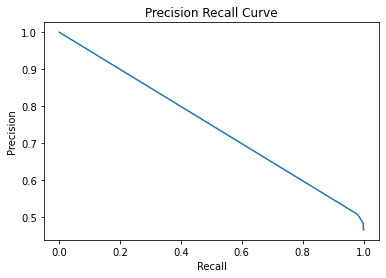

In [184]:
t, p , r = precision_recall(y_test, y_pred)
plt.plot(r, p)
plt.title("Precision Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[3425,  617],
       [ 158, 3358]])

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.8974596454088383

In [65]:
from sklearn.metrics import f1_score


f1_score(y_test, y_pred, average='macro')

0.8974515867127986